### Propósito: 
- Realizar uma análise exploratória dos dados, afim de encontrar padrões que nos tragam insights.
### Questões propostas: 

● Quais os 3 principais fatores que levam a um diagnóstico positivo de diabetes?

● Qual a chance de uma pessoa do sexo masculino com menos de 40 anos ter o diagnóstico positivo de diabetes?

● Qual a relação entre Polyphagia e o diagnóstico de diabetes?

Autora: Grazielly de Melo Oliveira



## Dependências

In [35]:
#Importando bibliotecas
import os
import pandas as pd
import numpy as np
import seaborn as sns
import cloudpickle
import matplotlib.pyplot as plt
from scipy.stats import norm
from pandas.api.types import is_numeric_dtype
from utils.eda import plotar_correlacao
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
%matplotlib inline
cmap = sns.diverging_palette(0,100,74,39,19,25, center='light', as_cmap=True) #heatmap

# Dados e Constantes

In [36]:
# Constantes
DATA_INTER_PATH = '../data/inter'
TRAIN_DATA = 'diabetes_train.parquet'
# Dados
df_train = pd.read_parquet(os.path.join(DATA_INTER_PATH, TRAIN_DATA))

# Análise Exploratória


In [37]:
# Separando colunas numéricas e categóricas. 
todas_as_variaveis = set(df_train.columns.tolist())
variaveis_categoricas = set(df_train.select_dtypes(include=['object']).columns.tolist())
variaveis_numericas = todas_as_variaveis - variaveis_categoricas

## Apriori 

O Apriori trabalha com o conceito de padrões frequentes, criando regras de associação entre o que foi pré estabelecido. 

Umas das medidas de desempenho consideradas nesta análise é o Lift que indica qual a chance de Y (nosso target) ser dado como positivo, se X (outras features do dataset) forem positivas também, e considerando toda a popularidade de Y. Em outras palavras, ele verifica qual informação nos traz mais conhecimento sobre a possibilidade de esses padrões serem encontrados juntos. 


Para realizar a análise, iremos converter nossas classes para inteiros

In [38]:
basket_train_features = df_train.drop(['idade'], axis=1)
dict_convert = {'yes':1, 'no':0, 'female':0, 'male':1}
basket_train_features = basket_train_features.replace(dict_convert)
for col in basket_train_features.columns.tolist():
    
    basket_train_features[col] = pd.to_numeric(basket_train_features[col])

In [39]:
# Aplicando a análise de padrões frequentes
# Aqui estamos lidando com padrões que aparecem, no mínimo 10% das vezes
frequent_itemsets = apriori(basket_train_features, min_support=0.1, use_colnames=True)


In [40]:
# Extraindo regras
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)

In [59]:
# Extraindo regras, cujo consequente seja diabetes (target = 1)
rules[(rules['consequents']=={('target')}) & (rules['lift']>1)].sort_values(by='lift', ascending=False).set_index('antecedents')

,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
antecedents,,,,,,,,
"(polyuria, polydipsia, cicatrizacao_retardada, perda_de_peso_repentina)",(target),0.145604,0.615385,0.145604,1.000000,1.625000,0.056002,inf
"(polydipsia, coceira, cicatrizacao_retardada, perda_de_peso_repentina)",(target),0.107143,0.615385,0.107143,1.000000,1.625000,0.041209,inf
"(polyphagia, paresia_parcial, polydipsia, perda_de_peso_repentina)",(target),0.167582,0.615385,0.167582,1.000000,1.625000,0.064455,inf
"(polyphagia, polydipsia, cicatrizacao_retardada, perda_de_peso_repentina)",(target),0.129121,0.615385,0.129121,1.000000,1.625000,0.049662,inf
"(polyphagia, polydipsia, coceira, perda_de_peso_repentina)",(target),0.115385,0.615385,0.115385,1.000000,1.625000,0.044379,inf
"(polyphagia, polydipsia, desfoque_visual, perda_de_peso_repentina)",(target),0.131868,0.615385,0.131868,1.000000,1.625000,0.050719,inf
"(fraqueza, polydipsia, cicatrizacao_retardada, perda_de_peso_repentina)",(target),0.115385,0.615385,0.115385,1.000000,1.625000,0.044379,inf
"(polyphagia, polydipsia, fraqueza, perda_de_peso_repentina)",(target),0.167582,0.615385,0.167582,1.000000,1.625000,0.064455,inf
"(paresia_parcial, polyuria, rigidez_muscular, fraqueza)",(target),0.151099,0.615385,0.151099,1.000000,1.625000,0.058115,inf


Extraímos a 5 regras com maior lift (que mais aumentam a probabilidade a posteriori do target positivo)

Em geral a polyuria é um bom indicador, pois aparece em vários padrões. Para exemplificação, extraímos apenas 5. Uma análise mais profunda é requerida para decidir o conjunto final de regras, para analisar a correlação das regras, por exemplo.

Com base no lift, extraímos:
- Possuir juntos: (polyuria, polydipsia, cicatrizacao_retardada, perda_de_peso_repentina) 
- Possuir juntos: (polydipsia, coceira, cicatrizacao_retardada, perda_de_peso_repentina) 
- Possuir juntos: (polyphagia, paresia_parcial, polydipsia, perda_de_peso_repentina)	
- Possuir Juntos: (polyphagia, polydipsia, cicatrizacao_retardada, perda_de_peso_repentina)
- Possuir juntos: (polyphagia, polydipsia, coceira, perda_de_peso_repentina)

Se o paciente tem polyuria, polydipsia, cicatrização retardada, perda de peso repentina, ele tem 62% a mais de chance de ter diabetes em estágio inicial.

## Questões Propostas

### Observação 

* Estou atribuindo que o target POSITIVO representa 1, e NEGATIVO representa 0. 
* A partir daqui, estou atribuindo que o sexo feminino será representado por 0, e o sexo masculino por 1. 

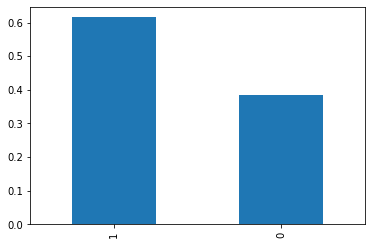

In [42]:
#Plot da distribuição da variável target.
df_train['genero'] = df_train['genero'].map({'female':0, 'male': 1})
df_train['target'].value_counts(normalize=True).plot.bar()
plt.show()

Plot do target para verificar se há desbalanceamento, para garantir uma melhor métrica de validação na modelagem

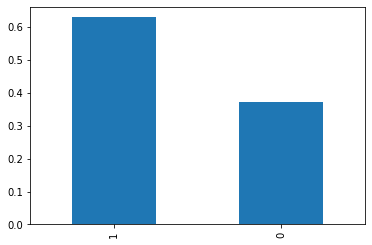

In [43]:
df_train['genero'].value_counts(normalize=True).plot.bar()
plt.show()

Na base há mais homens (>60%) que mulheres.

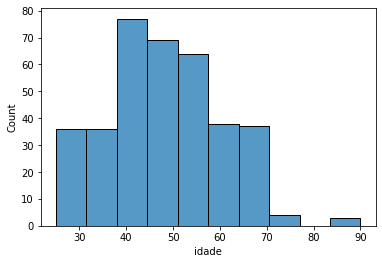

In [44]:
sns.histplot(df_train["idade"], kde=False, bins=10, palette="RdYlGn_r")
plt.show()

In [45]:
df_train["idade"].mean()

48.07692307692308

A média de idade é de 48 anos. E a grande maioria está acima dos 30.

Vamos ver a taxa de ocorrência de diabetes em obesos.

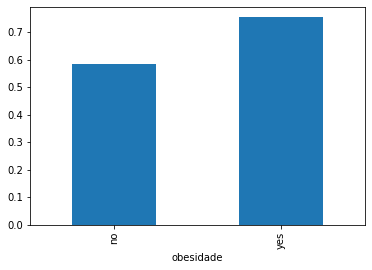

In [46]:
df_train.groupby('obesidade').mean()['target'].plot.bar()
plt.show()

Nesta base, cerca de mais de 75% de pessoas que são obesas também estão em estágio inicial de diabetes.

## Qual a relação entre Polyphagia e o diagnóstico de diabetes?

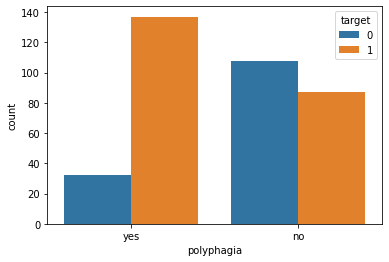

In [47]:
sns.countplot(x='polyphagia', hue="target", data=df_train)
plt.show()

In [48]:
df_train.groupby('polyphagia').mean()['target']

polyphagia
no     0.446154
yes    0.810651
Name: target, dtype: float64

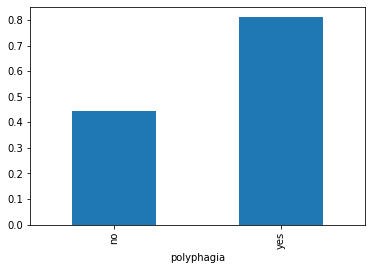

In [49]:
df_train.groupby('polyphagia').mean()['target'].plot.bar()
plt.show()

Polifagia é um sinal médico que significa fome excessiva e ingestão anormalmente alta de sólidos pela boca, pode-se notar que nesta amostra de dados cerca de 80% de pessoas que possuem`polyphagia` também possuem diabetes. Apenas 40% de quem não apresenta essa condição possui diabetes (o que é menor, inclusive, que a probabilidade apriori)

Dessa forma, isso nos leva a crer que há uma dependência entre esse fator e a ocorrência de diabetes.

## Qual a chance de uma pessoa do sexo masculino com menos de 40 anos ter o diagnóstico positivo de diabetes?


Considerando que a chance é a probabilidade da classe positiva pela probabilidade da classe negativa.

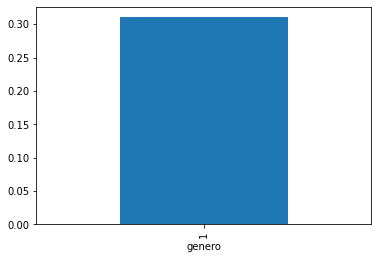

In [50]:
genero_masc = df_train[df_train['genero'] == 1]
genero_masc_40 = genero_masc[genero_masc['idade'] < 40]
genero_masc_40.groupby('genero').mean()['target'].plot.bar()
plt.show()

In [51]:
probabilidade_masc_40_positivo = genero_masc_40.groupby('genero').mean()['target'].values[0]
print(f"{probabilidade_masc_40_positivo*100} % dos homens com menos de 40 anos possuem diabetes em estágio inicial")

31.03448275862069 % dos homens com menos de 40 anos possuem diabetes em estágio inicial


In [52]:
# A chance será 
chance = round((probabilidade_masc_40_positivo/(1-probabilidade_masc_40_positivo)),2)
chance

0.45

Isto é aproximadamente uma chance de 5 casos de diabetes em estágio inicial para 11 pacientes sem diabetes em estágio inicial, dado que são homens com menos de 40 anos.

# Quais os 3 principais fatores que levam a um diagnóstico positivo de diabetes?

Esta última pergunta pode ser respondida de mais de uma forma. Primeiramente olharemos para medidas de correlação e associação. Posteriormente, tentaremos algo baseado em shapley values.

In [55]:
df_train.replace({'yes':1, 'no':0}, inplace=True)

Vamos avaliar a correlação point-biserial entre a variável idadee e o target e o cramer phi para as variáveis categóricas e o target. Embora a correlação e o cramer phi não sejam comparáveis diretamente, podemos ter uma noção da força das variáveis e elencar as candidatas as mais fortes.

Em se tratando de variável binária e target binário, o cramer phi é numericamente igual a correlação de pearson, além disso, a correlação point-biserial também é numericamente igual a correlação de pearson, no caso de uma variável numérica e outra binária. Por isso iremos utilizar o método de correlação para calcular ambas

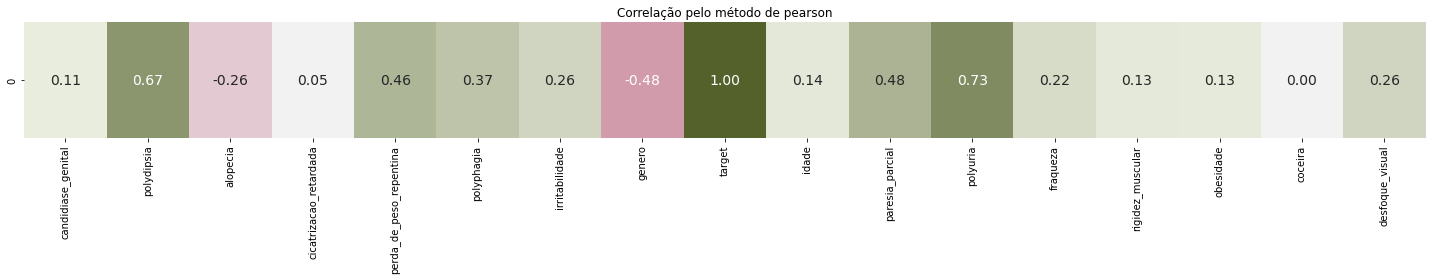

In [56]:
plotar_correlacao(todas_as_variaveis,df_train)


Logo pode-se notar que as variáveis `polyuria`, `polydipsia`, e `paresia parcial`, possuem uma associação mais alta em relação ao target. Em se tratando de correlação, a idade é correlacionada positivamente, indicando que quanto mais velho o paciente, mais chance dele estar em estágio inicial de diabetes. 

Apesar dos número apresentados, iremos submeter cada variável a testes para selecionar as melhroes.Precisamos, por exemplo, checar se a correção de 0.14 da idade tem significancia estatística antes de usá-la no modelo.

Destaco aqui o cramer phi da coceira, que deu 0. Contudo, esta condição compôs vários padrões frequentes. De fato, a análise de cramer e correlação são univariadas e incapazes de capturar interações. Dessa forma, a variável ainda pode ser útil se combinada com outras. A análise de padrões frequentes pode ajudar a criar features combinando coceira a outros fatores e essas novas features serem mais relevantes que as originais.